In [1]:
import os
import umap
import json
import torch
import itertools
from core import *
import numpy as np
import pandas as pd
import pickle as pkl
from torch import nn
import os.path as op
from tqdm import tqdm
from time import time
from copy import deepcopy
from torch.optim import Adam
from tpot import TPOTRegressor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from capsules.capsules import *
from matplotlib import rcParams
from IPython.display import Image
from matplotlib.lines import Line2D
from torch.autograd import Variable
from matplotlib.patches import Patch
from torch.optim.lr_scheduler import StepLR
from scipy.stats import spearmanr, pearsonr
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, recall_score

In [2]:
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

In [3]:
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.models import ApproximateGP, ExactGP 
from sklearn.metrics import accuracy_score
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel, GridInterpolationKernel
from gpytorch.mlls import VariationalELBO, VariationalELBOEmpirical, DeepApproximateMLL
from gpytorch.distributions import MultivariateNormal
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP

In [4]:
from collections import Counter
from keras.layers import Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential

In [5]:
np.random.seed(99)
torch.manual_seed(99)
torch.cuda.manual_seed(99)

In [6]:
data = pd.read_csv(
    "/home/bakirillov/Data/Svetlana_data/Table_S8_machine_learning_input.txt", index_col=0, sep="\t"
)

In [7]:
sequence_tuples = list(zip(data['genome input'], data['sgRNA input']))

In [8]:
def binarize_sequence(sequence):
    """
    converts a 26-base nucleotide string to a binarized array of shape (4,26)
    """
    arr = np.zeros((4, 23))
    for i in range(23):
        if sequence[i] == 'A':
            arr[0,i] = 1
        elif sequence[i] == 'C':
            arr[1,i] = 1
        elif sequence[i] == 'G':
            arr[2,i] = 1
        elif sequence[i] == 'T':
            arr[3,i] = 1
        else:
            raise(
                Exception(
                    'sequence contains characters other than A,G,C,T \n%s'%sequence
                )
            )
    return(arr)

GTGGGGCGAGGCGGTGAGTGTGG
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]]
(4, 23)


[]

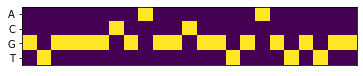

In [9]:
test_sequence = sequence_tuples[0][0][2:-1]
print(test_sequence)
print(binarize_sequence(test_sequence))
print(binarize_sequence(test_sequence).shape)
fig,ax=plt.subplots()
ax.imshow(binarize_sequence(test_sequence))
ax.set_yticks(range(4))
ax.set_yticklabels(list('ACGT'))
ax.set_xticks([])

In [10]:
stacked_arrs = [np.stack((binarize_sequence(genome_input[2:-1]), binarize_sequence(sgrna_input[2:-1])), axis=2) 
                for (genome_input, sgrna_input) in sequence_tuples]

In [11]:
X = np.concatenate([arr[np.newaxis] for arr in stacked_arrs])
y = data['mean relative gamma'].values
series = data['perfect match sgRNA']

In [12]:
print('X:', X.shape)
print('y:', y.shape)
print('series:', series.shape)

X: (26248, 4, 23, 2)
y: (26248,)
series: (26248,)


In [13]:
val_series = np.random.choice(
    np.unique(series), size=int(len(np.unique(series))*.20), replace=False
)
val_indices = np.where(np.isin(series, val_series))
train_indices = np.where(~np.isin(series, val_series))
X_train = X[train_indices]
X_val = X[val_indices]
y_train = y[train_indices]
y_val = y[val_indices]

In [14]:
nbins=5
y_train_clipped = y_train.clip(0,1)
y_train_binned, histbins = pd.cut(
    y_train_clipped, np.linspace(0,1,nbins+1), 
    labels=range(nbins), include_lowest=True, retbins=True
)

In [15]:
print('bin edges:', histbins)

bin edges: [0.  0.2 0.4 0.6 0.8 1. ]


In [16]:
class_weights = {k:1/float(v) for k,v in Counter(y_train_binned).items()}
class_weights[0] = class_weights[0] * 1.5
class_weights = {k:v/sum(class_weights.values()) for k,v in class_weights.items()}
sample_weights = [class_weights[Y] for Y in y_train_binned]
class_weights

{3: 0.24366538202754034,
 2: 0.2879094606727001,
 0: 0.050152613839668826,
 4: 0.13670716682036013,
 1: 0.2815653766397307}

In [17]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu', padding='same', input_shape=(4,23,2), data_format='channels_last'))
model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu', padding='same', data_format='channels_last'))
model.add(MaxPool2D(pool_size=(1,2), padding='same', data_format='channels_last'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=128, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(units=32, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
model.compile(loss='logcosh', metrics=['mse'], optimizer='adam')

# train the model for 8 epochs

In [18]:
model_history = model.fit(X_train, 
                          y_train.ravel(), 
                          sample_weight=np.array(sample_weights), 
                          batch_size=32, 
                          epochs=8, 
                          validation_data=(X_val, y_val.ravel()))

Epoch 1/8
657/657 [==============================] - 9s 13ms/step - loss: 0.0133 - mse: 0.3054 - val_loss: 0.0711 - val_mse: 0.1477
Epoch 2/8
657/657 [==============================] - 7s 11ms/step - loss: 0.0052 - mse: 0.1105 - val_loss: 0.0353 - val_mse: 0.0736
Epoch 3/8
657/657 [==============================] - 8s 12ms/step - loss: 0.0041 - mse: 0.0805 - val_loss: 0.0315 - val_mse: 0.0655
Epoch 4/8
657/657 [==============================] - 8s 11ms/step - loss: 0.0038 - mse: 0.0714 - val_loss: 0.0318 - val_mse: 0.0660
Epoch 5/8
657/657 [==============================] - 7s 11ms/step - loss: 0.0036 - mse: 0.0670 - val_loss: 0.0298 - val_mse: 0.0620
Epoch 6/8
657/657 [==============================] - 7s 11ms/step - loss: 0.0033 - mse: 0.0622 - val_loss: 0.0285 - val_mse: 0.0594
Epoch 7/8
657/657 [==============================] - 8s 12ms/step - loss: 0.0033 - mse: 0.0609 - val_loss: 0.0308 - val_mse: 0.0639
Epoch 8/8
657/657 [==============================] - 7s 11ms/step - loss: 0.

In [19]:
print('r squared = %.3f'%pearsonr(y_val, model.predict(X_val).ravel())[0]**2)

r squared = 0.627


In [20]:
model.save("Original_Jost_et_al.keras")

In [21]:
with open("../models/JostEtAl/model-u.json", "r") as ih:
    t = json.loads(ih.read())

In [22]:
rcParams["figure.figsize"] = (10, 5)

In [23]:
orig_predictions = model.predict(X_val)
y_hat_scaled = orig_predictions/np.max(orig_predictions)
y_val_scaled = y_val/np.max(y_val)

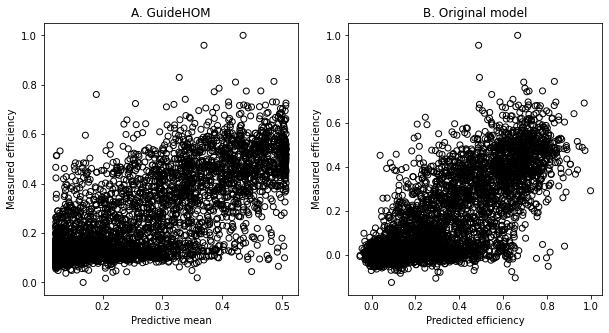

In [25]:
fig,ax = plt.subplots(ncols=2)
ax[1].scatter(y_hat_scaled, y_val_scaled, edgecolors="black", facecolors='none')#, marker='.', alpha=.2)
ax[1].set_xlabel('Predicted efficiency')
ax[1].set_ylabel('Measured efficiency')
ax[1].set_title('B. Original model');
ax[0].scatter(t["y_hat"], t["y"], edgecolors="black", facecolors='none')
ax[0].set_xlabel("Predictive mean")
ax[0].set_ylabel("Measured efficiency")
ax[0].set_title('A. GuideHOM');
#plt.show()